# Structured Names
This notebook describes how to use structured names to check SBML models for moiety balance.

In [7]:
import init
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule
from SBMLLint.common import simple_sbml
from SBMLLint.common.reaction import Reaction
from SBMLLint.tools import sbmllint
from SBMLLint.tools import print_reactions
from SBMLLint.common.simple_sbml import SimpleSBML

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

In [8]:
from SBMLLint.common.simple_sbml import modelIterator

In [9]:
iterator = modelIterator(initial=19, final=25)
for item in iterator:
    print(item.filename)

BIOMD0000000241_url.xml
BIOMD0000000350_url.xml
MODEL0847712949_url.xml
BIOMD0000000346_url.xml
BIOMD0000000256_url.xml
BIOMD0000000402_url.xml


In [10]:
import init
from SBMLLint.tools import sbmllint

# The first step in glycolysis, expressed
# in the Antimony language.
model = """
Glu + A__P_3 -> Glu_P + A_P_P; 1
Glu = 0
A_P_P_P = 0
Glu_P = 0
A_P_P = 0
"""
_ = sbmllint.lint(model, config_path="../SBMLLint/.sbmllint_cfg")


0 of 1 reactions have imbalances.



In [14]:
# The first step in glycolysis, with an error (wrongly goes to A instead of A_P_P)
model = """
Glu + A_P_P_P -> Glu_P + A_P; 1
"""
_ = sbmllint.lint(model, config_path="../SBMLLint/.sbmllint_cfg")


1 of 1 reactions have imbalances.

***_J0: Glu + A_P_P_P -> Glu_P + A_P
Excess moieties in reactants
  P: 1.00




In [15]:
cn.ANALYSIS_STRUCTURED_NAMES_DIR

'/home/ubuntu/SBMLLint/analysis/structured_names'

## Sturctured Names in BioModels

In [16]:
path = os.path.join(cn.ANALYSIS_STRUCTURED_NAMES_DIR, "analyze_structured_names.csv")
df_data = pd.read_csv(path)
df_data.head()

,filename,is_structured,num_boundary_reactions,total_reactions,num_imbalanced_reactions,num_balanced_reactions,frac_balanced_reactions,frac_Boundary_reactions
0,BIOMD0000000100_url.xml,False,5,10.0,10,0.0,0.0,0.500000
1,BIOMD0000000355_url.xml,True,12,17.0,17,0.0,0.0,0.705882
2,BIOMD0000000413_url.xml,False,4,9.0,9,0.0,0.0,0.444444
3,BIOMD0000000594_url.xml,True,0,120.0,120,0.0,0.0,0.000000
4,BIOMD0000000354_url.xml,False,6,11.0,11,0.0,0.0,0.545455


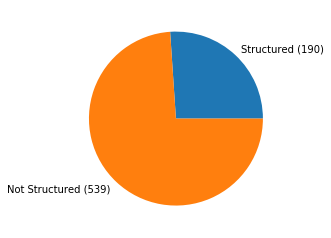

In [17]:
# Basic Statistics
num_structured = len(df_data[df_data[cn.IS_STRUCTURED]])
num_not_structured = len(df_data) - num_structured
_ = plt.pie([num_structured, num_not_structured], 
            labels=["Structured (%d)" % num_structured, "Not Structured (%d)" % num_not_structured])

Text(0, 0.5, 'Fraction of Models')

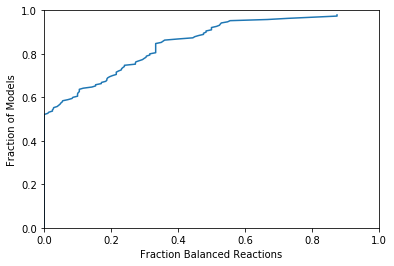

In [18]:
df_sort = df_data[df_data[cn.IS_STRUCTURED]]
df_sort = df_sort.sort_values(cn.FRAC_BALANCED_REACTIONS)
df_sort = df_sort.reset_index()
yv = [1.0*i/len(df_sort) for i in df_sort.index]
_ = plt.plot(df_sort[cn.FRAC_BALANCED_REACTIONS], yv)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Fraction Balanced Reactions")
plt.ylabel("Fraction of Models")

/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal



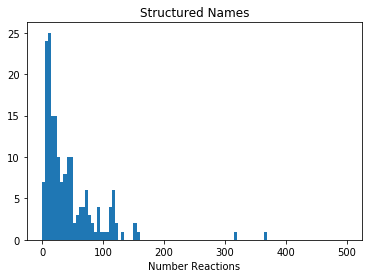

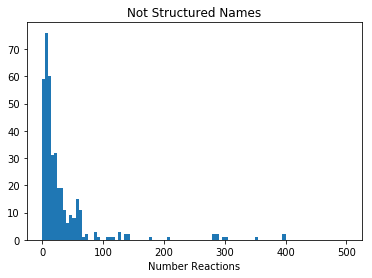

In [19]:
def plotIsStructured(df, val):
    df1 = df[df[cn.IS_STRUCTURED] == val]
    plt.hist(df1[cn.TOTAL_REACTIONS], bins=100, range=(0, 500))
    if val:
        title = "Structured Names"
    else:
        title = "Not Structured Names"
    plt.title(title)
    plt.xlabel("Number Reactions")
    plt.show()
plotIsStructured(df_data, True)
plotIsStructured(df_data, False)

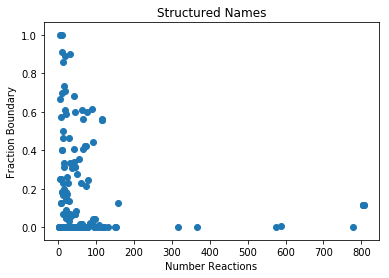

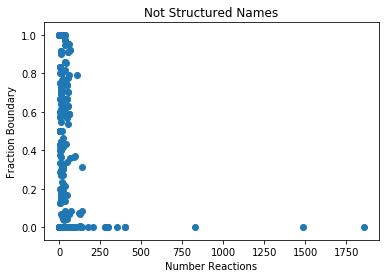

In [20]:
def plotFrcBoundary(df, val):
    df1 = df[df[cn.IS_STRUCTURED] == val]
    plt.scatter(df1[cn.TOTAL_REACTIONS], df1[cn.FRAC_BOUNDARY_REACTIONS])
    if val:
        title = "Structured Names"
    else:
        title = "Not Structured Names"
    plt.title(title)
    plt.xlabel("Number Reactions")
    plt.ylabel("Fraction Boundary")
    plt.show()
plotFrcBoundary(df_data, True)
plotFrcBoundary(df_data, False)

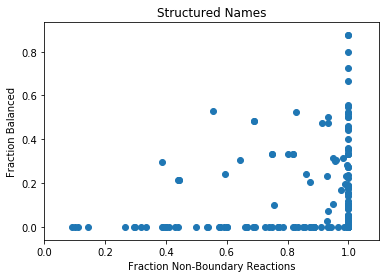

In [21]:
def plotFracBalanced(df):
    df1 = df[df[cn.IS_STRUCTURED]]
    xv = (1.0*df1[cn.TOTAL_REACTIONS] - df1[cn.NUM_BOUNDARY_REACTIONS]) / df1[cn.TOTAL_REACTIONS]
    plt.scatter(xv, df1[cn.FRAC_BALANCED_REACTIONS])
    title = "Structured Names"
    plt.title(title)
    plt.xlabel("Fraction Non-Boundary Reactions")
    plt.ylabel("Fraction Balanced")
    plt.xlim([0, 1.1])
    plt.show()
plotFracBalanced(df_data)

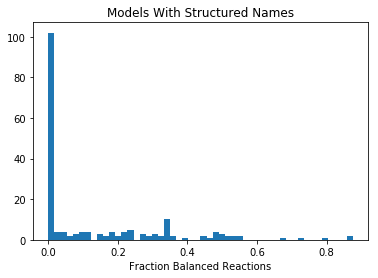

In [22]:
# Histogram of fraction balanced for structured names
def plotFracBalancedHist(df):
    df1 = df[df[cn.IS_STRUCTURED]]
    plt.hist(df1[cn.FRAC_BALANCED_REACTIONS], bins=50)
    title = "Models With Structured Names"
    plt.title(title)
    plt.xlabel("Fraction Balanced Reactions")
    plt.show()
plotFracBalancedHist(df_data)

## Detailed Look at Putative Structured Names

**Observations**
1. Some cases where doing ad hoc structured names that with little change can balance. For example:   
   1. BIOMD0000000192_url.xml: RCC1_RanGDP -> RCC1_Ran + GDP, RCC1_Ran + GTP -> RCC1_RanGTP
   1. BIOMD0000000010_url.xml: MKKK -> MKKK_P, MKKK_P -> MKKK

In [23]:
df = df_data[df_data[cn.IS_STRUCTURED]]
for _, row in df.iterrows():
    path = os.path.join(cn.BIOMODELS_DIR, row[cn.FILENAME])
    try:
        print("\n%s" % row[cn.FILENAME])
        print_reactions.prettyPrint(path, is_include_kinetics=False, is_include_label=False)
    except:
        pass


BIOMD0000000355_url.xml
 -> IP3
CaI -> CaS
CaS -> CaI
IP3 -> 
 -> g
g -> 
 -> CaI
CaI -> 
 -> mwaf195932_a72c_4552_8cf2_b349b15d39c4
mwaf195932_a72c_4552_8cf2_b349b15d39c4 -> 
 -> mw0ebc76ad_49d7_4845_8f88_04d443fbe7f3
 -> mw7cb2644a_384a_4bbb_93fd_fd686e01d7cb
mw7cb2644a_384a_4bbb_93fd_fd686e01d7cb -> 
mw0ebc76ad_49d7_4845_8f88_04d443fbe7f3 -> 
CaI -> mw013a7c64_a9ec_483c_b3b8_ed658337ee95
CaS -> mw013a7c64_a9ec_483c_b3b8_ed658337ee95
mw013a7c64_a9ec_483c_b3b8_ed658337ee95 -> CaI

BIOMD0000000594_url.xml
EGFR_10UU -> EGFR_00UU
EGFR_01UU -> EGFR_00UU
EGFR_11UU -> EGFR_01UU
EGFR_11UU -> EGFR_10UU
EGFR_11CU -> EGFR_10CU
EGFR_11LU -> EGFR_10LU
EGFR_11UG -> EGFR_01UG
EGFR_11UL -> EGFR_01UL
EGFR_02UU -> EGFR_01UU
EGFR_02UG -> EGFR_01UG
EGFR_02UL -> EGFR_01UL
EGFR_12UU -> EGFR_02UU
EGFR_12UU -> EGFR_11UU
EGFR_12CU -> EGFR_11CU
EGFR_12LU -> EGFR_11LU
EGFR_12UG -> EGFR_02UG
EGFR_12UG -> EGFR_11UG
EGFR_12UL -> EGFR_02UL
EGFR_12UL -> EGFR_11UL
EGFR_12CG -> EGFR_11CG
EGFR_12CC -> EGFR_11CC
EGFR_

RII + RI -> lRIRII
lRIRII -> 
lRIRII -> 
lRIRII -> lRIRII_endo
 -> RI
RI -> 
RI -> RI_endo
RI_endo -> RI
lRIRII_endo -> RI + RII
 -> RII
RII -> 
RII -> RII_endo
RII_endo -> RII

BIOMD0000000536_url.xml
mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc + mwf626e95e_543f_41e4_aad4_c6bf60ab345b -> mw03db56ac_8dc6_4931_ae82_fef706d2ee3d
mw03db56ac_8dc6_4931_ae82_fef706d2ee3d + mwbbbce920_e8dd_4320_9386_fc94bfb2fc99 -> mw810ff751_fa4e_4143_bd50_169b3e325e1e
 -> mwf626e95e_543f_41e4_aad4_c6bf60ab345b
mwf626e95e_543f_41e4_aad4_c6bf60ab345b -> 
mw114aa90f_5f5b_4fe8_9406_361c8489b6a1 -> 
mw4638f126_8cb8_4021_ab41_6ae195743ba0 + mw80848184_e2dd_47ce_86d7_7a21479342bd -> mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a
mw10315fa3_6f13_4618_bda8_a8694bd3c374 + mw0adf3eb4_a196_4c48_b10d_4e9e9faaf9e1 -> mw7d86cc23_a1af_44c3_bdb9_71e9b1bb2a83
mw7d86cc23_a1af_44c3_bdb9_71e9b1bb2a83 + mw80848184_e2dd_47ce_86d7_7a21479342bd -> mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a
mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a -> mw0eb6c959_d408_4

mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc + mwf626e95e_543f_41e4_aad4_c6bf60ab345b -> mw03db56ac_8dc6_4931_ae82_fef706d2ee3d
mw03db56ac_8dc6_4931_ae82_fef706d2ee3d + mwbbbce920_e8dd_4320_9386_fc94bfb2fc99 -> mw810ff751_fa4e_4143_bd50_169b3e325e1e
 -> mwf626e95e_543f_41e4_aad4_c6bf60ab345b
mwf626e95e_543f_41e4_aad4_c6bf60ab345b -> 
mw114aa90f_5f5b_4fe8_9406_361c8489b6a1 -> 
mw4638f126_8cb8_4021_ab41_6ae195743ba0 + mw80848184_e2dd_47ce_86d7_7a21479342bd -> mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a
mw10315fa3_6f13_4618_bda8_a8694bd3c374 + mw0adf3eb4_a196_4c48_b10d_4e9e9faaf9e1 -> mw7d86cc23_a1af_44c3_bdb9_71e9b1bb2a83
mw7d86cc23_a1af_44c3_bdb9_71e9b1bb2a83 + mw80848184_e2dd_47ce_86d7_7a21479342bd -> mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a
mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a -> mw0eb6c959_d408_45a0_a450_928b8c5876bb
mw42054cd7_17af_46da_970c_7f99151906ad + mw0eb6c959_d408_45a0_a450_928b8c5876bb -> mw39c2e431_fdc3_4964_be29_6ca856620b1b + mw0eb6c959_d408_45a0_a450_928b8c5876bb
mw39c2e431_fdc3_4

 -> x1
x1 + x2 -> Pre_MPF
x1 -> 
x3 -> x2
Pre_MPF -> x3
x3 -> Pre_MPF
y4 -> x4
x4 -> y4
y5 -> x5
x5 -> y5
y6 -> x6
x6 -> y6
 -> m

BIOMD0000000334_url.xml
II_f + 100.00 LIPID -> II_l
mIIa_f + 100.00 LIPID -> mIIa_l
V_f + 100.00 LIPID -> V_l
Va_f + 100.00 LIPID -> Va_l
VII_f + 100.00 LIPID -> VII_l
VIIa_f + 100.00 LIPID -> VIIa_l
VIII_f + 100.00 LIPID -> VIII_l
VIIIa_f + 100.00 LIPID -> VIIIa_l
IX_f + 100.00 LIPID -> IX_l
IXa_f + 100.00 LIPID -> IXa_l
X_f + 100.00 LIPID -> X_l
Xa_f + 100.00 LIPID -> Xa_l
APC_f + 100.00 LIPID -> APC_l
PS_f + 100.00 LIPID -> PS_l
VIIIai_f + 100.00 LIPID -> VIIIai_l
Vai_f + 100.00 LIPID -> Vai_l
PC_f + 100.00 LIPID -> PC_l
VIIa_l + TF_l -> TF_VIIa_l
VII_l + TF_l -> TF_VII_l
IX_l + TF_VIIa_l -> TF_VIIa_IX_l
TF_VIIa_IX_l -> TF_VIIa_l + IXa_l
X_l + TF_VIIa_l -> TF_VIIa_X_l
TF_VIIa_X_l -> TF_VIIa_Xa_l
TF_VIIa_Xa_l -> Xa_l + TF_VIIa_l
Xa_l + TF_VII_l -> TF_VII_Xa_l
TF_VII_Xa_l -> Xa_l + TF_VIIa_l
VIIIa_l + IXa_l -> IXa_VIIIa_l
Va_l + Xa_l -> Xa_Va_l
X_l + IXa_V

mwe2fff28d_182c_4a1c_9882_f17774c0958a + mw93907b2d_53db_4080_9e3f_3eb304441ab9 -> mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8
mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8 + mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8 -> mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3
mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3 -> mwbfcf6773_1915_432c_b1d2_1f246094cc74
mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mw3c2e1b43_29ca_491a_93e9_c723a993d6fb -> mw5198d3c2_879c_4f0d_b4f8_cd40efe0b1cf
mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mwe57c3282_5935_405c_8c0b_7fadb7a5de17 -> mw954e8fcb_ac0a_459d_8878_f19080208a17
mw5198d3c2_879c_4f0d_b4f8_cd40efe0b1cf -> mwa98802cb_c977_4fe0_9e67_5000904c2c36
mw954e8fcb_ac0a_459d_8878_f19080208a17 -> mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3 + mwe57c3282_5935_405c_8c0b_7fadb7a5de17
mwa98802cb_c977_4fe0_9e67_5000904c2c36 -> mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mwa0349407_8187_48fc_9e94_5698ccc4e06d
mwa0349407_8187_48fc_9e94_5698ccc4e06d + mwe57c3282_5935_405c_8c0b_7fadb7a5de17 -> mwf9999977_6f0e_4e35_9b

R_cw0 -> R_cw1
R_ccw0 -> R_ccw1
R_cw1 -> R_cw2
R_ccw1 -> R_ccw2
R_cw2 -> R_cw3
R_ccw2 -> R_ccw3
R_cw3 -> R_cw4
R_ccw3 -> R_ccw4
R_cw4 -> R_cw5
R_ccw4 -> R_ccw5
R_cw5 -> R_cw6
R_ccw5 -> R_ccw6
R_cw6 -> R_cw7
R_ccw6 -> R_ccw7
R_cw7 -> R_cw8
R_ccw7 -> R_ccw8
R_cw8 -> R_cw9
R_ccw8 -> R_ccw9
R_cw9 -> R_cw10
R_ccw9 -> R_ccw10
R_cw10 -> R_cw11
R_ccw10 -> R_ccw11
R_cw11 -> R_cw12
R_ccw11 -> R_ccw12
R_cw12 -> R_cw13
R_ccw12 -> R_ccw13
R_cw13 -> R_cw14
R_ccw13 -> R_ccw14
R_cw14 -> R_cw15
R_ccw14 -> R_ccw15
R_cw15 -> R_cw16
R_ccw15 -> R_ccw16
R_cw16 -> R_cw17
R_ccw16 -> R_ccw17
R_cw17 -> R_cw18
R_ccw17 -> R_ccw18
R_cw18 -> R_cw19
R_ccw18 -> R_ccw19
R_cw19 -> R_cw20
R_ccw19 -> R_ccw20
R_cw20 -> R_cw21
R_ccw20 -> R_ccw21
R_cw21 -> R_cw22
R_ccw21 -> R_ccw22
R_cw22 -> R_cw23
R_ccw22 -> R_ccw23
R_cw23 -> R_cw24
R_ccw23 -> R_ccw24
R_cw24 -> R_cw25
R_ccw24 -> R_ccw25
R_cw25 -> R_cw26
R_ccw25 -> R_ccw26
R_cw26 -> R_cw27
R_ccw26 -> R_ccw27
R_cw27 -> R_cw28
R_ccw27 -> R_ccw28
R_cw28 -> R_cw29
R_ccw28 -> R_

AA -> T1R_surf
T1R_surf -> T1R_endo
T1R_endo -> T1R_surf
T1R_endo -> empty_degraded
AA -> T2R_surf
T2R_surf -> T2R_endo
T2R_endo -> T2R_surf
T2R_endo -> empty_degraded
TGF_beta_ex + T2R_surf + T1R_surf -> LRC_surf
LRC_surf -> LRC_endo
LRC_endo -> empty_degraded
LRC_endo -> T1R_endo + T2R_endo + TGF_beta_endo
TGF_beta_endo -> empty_degraded
Smad2c -> Smad2n
Smad2n -> Smad2c
Smad4c -> Smad4n
Smad4n -> Smad4c
Smad2c -> PSmad2c
PSmad2c -> PSmad2n
PSmad2n -> PSmad2c
PSmad2c + Smad4c -> PSmad2_Smad4_c
PSmad2_Smad4_c -> PSmad2_Smad4_n
PSmad2_Smad4_n -> PSmad2n + Smad4n
PSmad2n -> Smad2n
2.00 PSmad2c -> PSmad2_PSmad2_c
PSmad2_PSmad2_c -> PSmad2_PSmad2_n
PSmad2_PSmad2_n -> 2.00 PSmad2n
LRC_surf -> empty_degraded
TGF_beta_ex -> TGF_beta_ns

BIOMD0000000235_url.xml
PRE_E_Gcad -> mRNA_E_Gcad
PRE_E_Notch -> mRNA_E_Notch
PRE_E_Otx -> mRNA_E_Otx
PRE_E_SoxB1 -> mRNA_E_SoxB1
PRE_E_SuH -> mRNA_E_SuH
PRE_E_UMR -> mRNA_E_UMR
PRE_E_UVAOtx -> mRNA_E_UVAOtx
PRE_E_UbiqSoxB1 -> mRNA_E_UbiqSoxB1
PRE_E_VEGF -> m

 -> Z
 -> Z
Z -> Y
Y -> Z
Y -> Z
Z -> 
 -> W_star

BIOMD0000000636_url.xml
mw0b46978f_b522_4cde_97f0_574cd7dbbae7 + mwbe974953_e869_4622_b4a8_745555c8d7fd -> A2ARAdnGolf
A2ARAdn + mw351f6cee_3e64_4b8e_8e60_24b1aca99a92 -> A2ARAdnGolf
A2AR + mw351f6cee_3e64_4b8e_8e60_24b1aca99a92 -> mw0b46978f_b522_4cde_97f0_574cd7dbbae7
A2AR + mwbe974953_e869_4622_b4a8_745555c8d7fd -> A2ARAdn
mwf82770b9_766a_4c4e_851a_d76da19e8517 + mwd8ea533a_c66e_4de4_8c5c_0d4201d8c8a2 -> mwd86ce0dc_7329_4b27_9de0_ee6bffee3083
mw9d5c5c9d_301d_4e43_ba7b_7d21ccbdc2c2 + mwd8ea533a_c66e_4de4_8c5c_0d4201d8c8a2 -> mwe4e36b8e_18b8_4c76_bd46_13614b71da5c
mw3e1a2fbf_37b1_490c_9528_6cb6bbf11b21 + mwd86ce0dc_7329_4b27_9de0_ee6bffee3083 -> mwe4e36b8e_18b8_4c76_bd46_13614b71da5c
mw3e1a2fbf_37b1_490c_9528_6cb6bbf11b21 + mwf82770b9_766a_4c4e_851a_d76da19e8517 -> mw9d5c5c9d_301d_4e43_ba7b_7d21ccbdc2c2
mw724f1afe_8032_40ae_96ca_808ab7b8b943 + mw8e34c23f_1891_4dc9_8f97_dc2f12a1706c -> mwfe9ed415_d5af_469c_a549_d8981f1eb01f
mw724f1afe_

Ca_Cytosol + D28k_high_Cytosol -> D28kB_high_Cytosol
D28k_D_Cytosol + Ca_D_Cytosol -> D28kB_D_Cytosol
PABCa_Cytosol -> 
PA_Cytosol -> 
CGB_D_Cytosol -> 
PA_Cytosol + Mg_Cytosol -> PABMg_Cytosol
PA_D_Cytosol -> 
IP3_Cytosol -> 
D28kB_high_Cytosol -> 
D28k_Cytosol -> 
CGB_Cytosol -> 
Ca_D_Cytosol + CG_D_Cytosol -> CGB_D_Cytosol
IP3_D_Cytosol -> 
Ca_D_Cytosol -> 
 -> IP3_Cytosol
Ca_Cytosol -> Ca_ER
Ca_D_Cytosol -> Ca_D_ER
Ca_D_Cytosol -> Ca_D_ER
Ca_Cytosol -> Ca_ER
Ca_Extracellular -> Ca_Cytosol
Ca_Cytosol -> Ca_ER
Ca_D_Extracellular -> Ca_D_Cytosol
Ca_D_Cytosol -> Ca_D_ER

BIOMD0000000481_url.xml
LH_Pit -> LH_Bld
FSH_Pit -> FSH_Bld
GnRH_Hyp -> snk_GnRH_Hyp
src_CL -> CL
src_GnRH -> GnRH_Hyp
src_E2 -> E2
src_P4 -> P4
src_Inh -> Inh
src_OT -> OT
src_Enz -> Enz
src_PGF -> PGF
GnRH_Pit -> snk_GnRH_Pit
LH_Bld -> snk_LH
FSH_Bld -> snk_FSH
P4 -> snk_P4
E2 -> snk_E2
Inh -> snk_Inh
OT -> snk_OT
Enz -> snk_Enz
PGF -> snk_PGF
IOF -> snk_IOF
Foll -> snk_Foll
CL -> snk_CL
src_LH -> LH_Pit
src_FSH -> F

R_cw0 -> R_cw1
R_ccw0 -> R_ccw1
R_cw1 -> R_cw2
R_ccw1 -> R_ccw2
R_cw2 -> R_cw3
R_ccw2 -> R_ccw3
R_cw3 -> R_cw4
R_ccw3 -> R_ccw4
R_cw4 -> R_cw5
R_ccw4 -> R_ccw5
R_cw5 -> R_cw6
R_ccw5 -> R_ccw6
R_cw6 -> R_cw7
R_ccw6 -> R_ccw7
R_cw7 -> R_cw8
R_ccw7 -> R_ccw8
R_cw8 -> R_cw9
R_ccw8 -> R_ccw9
R_cw9 -> R_cw10
R_ccw9 -> R_ccw10
R_cw10 -> R_cw11
R_ccw10 -> R_ccw11
R_cw11 -> R_cw12
R_ccw11 -> R_ccw12
R_cw12 -> R_cw13
R_ccw12 -> R_ccw13
R_cw13 -> R_cw14
R_ccw13 -> R_ccw14
R_cw14 -> R_cw15
R_ccw14 -> R_ccw15
R_cw15 -> R_cw16
R_ccw15 -> R_ccw16
R_cw16 -> R_cw17
R_ccw16 -> R_ccw17
R_cw17 -> R_cw18
R_ccw17 -> R_ccw18
R_cw18 -> R_cw19
R_ccw18 -> R_ccw19
R_cw19 -> R_cw20
R_ccw19 -> R_ccw20
R_cw20 -> R_cw21
R_ccw20 -> R_ccw21
R_cw21 -> R_cw22
R_ccw21 -> R_ccw22
R_cw22 -> R_cw23
R_ccw22 -> R_ccw23
R_cw23 -> R_cw24
R_ccw23 -> R_ccw24
R_cw24 -> R_cw25
R_ccw24 -> R_ccw25
R_cw25 -> R_cw26
R_ccw25 -> R_ccw26
R_cw26 -> R_cw27
R_ccw26 -> R_ccw27
R_cw27 -> R_cw28
R_ccw27 -> R_ccw28
R_cw28 -> R_cw29
R_ccw28 -> R_

mwe2fff28d_182c_4a1c_9882_f17774c0958a + mw93907b2d_53db_4080_9e3f_3eb304441ab9 -> mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8
mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8 + mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8 -> mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3
mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3 -> mwbfcf6773_1915_432c_b1d2_1f246094cc74
mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mw3c2e1b43_29ca_491a_93e9_c723a993d6fb -> mw5198d3c2_879c_4f0d_b4f8_cd40efe0b1cf
mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mwe57c3282_5935_405c_8c0b_7fadb7a5de17 -> mw954e8fcb_ac0a_459d_8878_f19080208a17
mw5198d3c2_879c_4f0d_b4f8_cd40efe0b1cf -> mwa98802cb_c977_4fe0_9e67_5000904c2c36
mw954e8fcb_ac0a_459d_8878_f19080208a17 -> mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3 + mwe57c3282_5935_405c_8c0b_7fadb7a5de17
mwa98802cb_c977_4fe0_9e67_5000904c2c36 -> mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mwa0349407_8187_48fc_9e94_5698ccc4e06d
mwa0349407_8187_48fc_9e94_5698ccc4e06d + mwe57c3282_5935_405c_8c0b_7fadb7a5de17 -> mwf9999977_6f0e_4e35_9b

R_cw0 -> R_cw1
R_ccw0 -> R_ccw1
R_cw1 -> R_cw2
R_ccw1 -> R_ccw2
R_cw2 -> R_cw3
R_ccw2 -> R_ccw3
R_cw3 -> R_cw4
R_ccw3 -> R_ccw4
R_cw4 -> R_cw5
R_ccw4 -> R_ccw5
R_cw5 -> R_cw6
R_ccw5 -> R_ccw6
R_cw6 -> R_cw7
R_ccw6 -> R_ccw7
R_cw7 -> R_cw8
R_ccw7 -> R_ccw8
R_cw8 -> R_cw9
R_ccw8 -> R_ccw9
R_cw9 -> R_cw10
R_ccw9 -> R_ccw10
R_cw10 -> R_cw11
R_ccw10 -> R_ccw11
R_cw11 -> R_cw12
R_ccw11 -> R_ccw12
R_cw12 -> R_cw13
R_ccw12 -> R_ccw13
R_cw13 -> R_cw14
R_ccw13 -> R_ccw14
R_cw14 -> R_cw15
R_ccw14 -> R_ccw15
R_cw15 -> R_cw16
R_ccw15 -> R_ccw16
R_cw16 -> R_cw17
R_ccw16 -> R_ccw17
R_cw17 -> R_cw18
R_ccw17 -> R_ccw18
R_cw18 -> R_cw19
R_ccw18 -> R_ccw19
R_cw19 -> R_cw20
R_ccw19 -> R_ccw20
R_cw20 -> R_cw21
R_ccw20 -> R_ccw21
R_cw21 -> R_cw22
R_ccw21 -> R_ccw22
R_cw22 -> R_cw23
R_ccw22 -> R_ccw23
R_cw23 -> R_cw24
R_ccw23 -> R_ccw24
R_cw24 -> R_cw25
R_ccw24 -> R_ccw25
R_cw25 -> R_cw26
R_ccw25 -> R_ccw26
R_cw26 -> R_cw27
R_ccw26 -> R_ccw27
R_cw27 -> R_cw28
R_ccw27 -> R_ccw28
R_cw28 -> R_cw29
R_ccw28 -> R_

R_cw0 -> R_cw1
R_ccw0 -> R_ccw1
R_cw1 -> R_cw2
R_ccw1 -> R_ccw2
R_cw2 -> R_cw3
R_ccw2 -> R_ccw3
R_cw3 -> R_cw4
R_ccw3 -> R_ccw4
R_cw4 -> R_cw5
R_ccw4 -> R_ccw5
R_cw5 -> R_cw6
R_ccw5 -> R_ccw6
R_cw6 -> R_cw7
R_ccw6 -> R_ccw7
R_cw7 -> R_cw8
R_ccw7 -> R_ccw8
R_cw8 -> R_cw9
R_ccw8 -> R_ccw9
R_cw9 -> R_cw10
R_ccw9 -> R_ccw10
R_cw10 -> R_cw11
R_ccw10 -> R_ccw11
R_cw11 -> R_cw12
R_ccw11 -> R_ccw12
R_cw12 -> R_cw13
R_ccw12 -> R_ccw13
R_cw13 -> R_cw14
R_ccw13 -> R_ccw14
R_cw14 -> R_cw15
R_ccw14 -> R_ccw15
R_cw15 -> R_cw16
R_ccw15 -> R_ccw16
R_cw16 -> R_cw17
R_ccw16 -> R_ccw17
R_cw17 -> R_cw18
R_ccw17 -> R_ccw18
R_cw18 -> R_cw19
R_ccw18 -> R_ccw19
R_cw19 -> R_cw20
R_ccw19 -> R_ccw20
R_cw20 -> R_cw21
R_ccw20 -> R_ccw21
R_cw21 -> R_cw22
R_ccw21 -> R_ccw22
R_cw22 -> R_cw23
R_ccw22 -> R_ccw23
R_cw23 -> R_cw24
R_ccw23 -> R_ccw24
R_cw24 -> R_cw25
R_ccw24 -> R_ccw25
R_cw25 -> R_cw26
R_ccw25 -> R_ccw26
R_cw26 -> R_cw27
R_ccw26 -> R_ccw27
R_cw27 -> R_cw28
R_ccw27 -> R_ccw28
R_cw28 -> R_cw29
R_ccw28 -> R_

iso_BAR_G_cyto_mem -> iso_BAR_cyto_mem + bg_cyto + G_a_s_cyto
cAMP_cyto -> AMP_cyto
B_Raf_active_cyto -> B_Raf_cyto
BAR_cyto_mem + iso_extra -> iso_BAR_cyto_mem
cAMP_cyto -> AMP_cyto
GRK_cyto + bg_cyto -> GRK_bg_cyto
MAPK_cyto -> MAPK_active_cyto
B_Raf_cyto -> B_Raf_active_cyto
ATP_cyto -> cAMP_cyto
G_a_s_cyto -> G_GDP_cyto
bg_cyto + G_GDP_cyto -> G_protein_cyto
iso_BAR_cyto_mem + G_protein_cyto -> iso_BAR_G_cyto_mem
c3_R2C2_cyto + cAMP_cyto -> PKA_cyto
cAMP_cyto -> AMP_cyto
PTP_cyto -> PTP_PKA_cyto
G_a_s_cyto + AC_cyto_mem -> AC_active_cyto_mem
ATP_cyto -> cAMP_cyto
R2C2_cyto + cAMP_cyto -> c_R2C2_cyto
iso_BAR_cyto_mem -> iso_BAR_p_cyto_mem
PDE4_cyto -> PDE4_P_cyto
MEK_cyto -> MEK_active_cyto
MAPK_active_cyto -> MAPK_cyto
c_R2C2_cyto + cAMP_cyto -> c2_R2C2_cyto
MAPK_active_cyto -> MAPK_cyto
iso_extra + BAR_G_cyto_mem -> iso_BAR_G_cyto_mem
MAPK_active_cyto -> MAPK_cyto
PDE4_P_cyto -> PDE4_cyto
PTP_PKA_cyto -> PTP_cyto
iso_BAR_cyto_mem -> iso_BAR_p_cyto_mem
BAR_cyto_mem + G_protein_cyto

b_gsh -> b_cys + b_gly + b_glu
b_gsg -> 2.00 b_cys + 2.00 b_gly + 2.00 b_glu
b_cys -> 
b_cys -> 
b_glu -> 
b_gly -> 
b_gsh -> 
b_gsg -> 
 -> b_cys
 -> b_gly
 -> b_glu
c_gsh -> b_gsh
c_gsh -> b_gsh
c_gsg -> b_gsg
c_gsg -> b_gsg
b_cys -> c_cys
b_glu -> c_glu
b_gly -> c_gly
b_ser -> c_ser
b_met -> met
m_10f -> m_thf
m_thf + m_ser -> m_gly + m_2cf
m_thf + m_coo -> m_10f
m_thf + HCHO -> m_2cf
m_thf + m_gly -> m_2cf + CO
m_thf + src -> m_2cf + m_gly
m_thf + dmg -> m_2cf + src
m_2cf -> m_1cf
m_1cf -> m_10f
3.00 m_ser -> c_ser
3.00 m_coo -> c_coo
3.00 m_gly -> c_gly
c_5mf + hcy -> c_thf + met
c_dhf + NADPH -> c_thf
c_10f -> c_thf
c_10f + GAR -> aic + c_thf
c_thf + c_coo -> c_10f
c_ser + c_thf -> c_gly + c_2cf
c_thf + HCHO -> c_2cf
DUMP + c_2cf -> c_dhf
c_2cf + NADPH -> c_5mf
c_2cf -> c_1cf + NADPH
c_1cf -> c_10f
c_10f + aic -> c_thf
hcy + BET -> met + dmg
met -> sam
met -> sam
sam + c_gly -> sah + src
sam -> sah
sah -> hcy
c_ser -> 
hcy + c_ser -> cyt
cyt -> c_cys
c_cys + c_glu -> glc
c_cys ->

mw4d2e70a7_f499_461d_ae18_bc53b365b091 -> mw8cc67de0_64e6_428f_ab09_4c2825cc172c
mw8cc67de0_64e6_428f_ab09_4c2825cc172c -> mw6ee00a71_ab68_454b_b1cd_60c1ebd19cfa
mw6ee00a71_ab68_454b_b1cd_60c1ebd19cfa -> mw136c8391_14f4_4a28_83a3_35cc74a2e040
mw6ee00a71_ab68_454b_b1cd_60c1ebd19cfa -> mwf8cfed1b_6fcf_4cba_bc30_b44490814a7a
mw136c8391_14f4_4a28_83a3_35cc74a2e040 -> mw2dc73059_a841_48d5_b4bd_3ac24d94c42e
mw7204ab72_2ee5_4b92_b420_2583dacc4343 -> mw6939cefe_e7ff_4a3f_b45b_a9234d1b5573
mw6939cefe_e7ff_4a3f_b45b_a9234d1b5573 -> mw8a358487_b18b_42df_a646_cd75eb5bfcc2
mw2dc73059_a841_48d5_b4bd_3ac24d94c42e -> mw7204ab72_2ee5_4b92_b420_2583dacc4343
mwf8cfed1b_6fcf_4cba_bc30_b44490814a7a -> mw702be69a_eb4f_425e_87c7_ef7d85254536
mw702be69a_eb4f_425e_87c7_ef7d85254536 -> mwbee11634_55df_4a3f_998a_634dfaf46fd7
mwbee11634_55df_4a3f_998a_634dfaf46fd7 -> mwd9e7a9b9_6f1b_4bbc_afa5_6cb192b62ce8
mwd9e7a9b9_6f1b_4bbc_afa5_6cb192b62ce8 -> mwfed5a135_c91b_4d20_91b2_3a61723544dd
mw6ee00a71_ab68_454b_b1cd_60

Pyr_c -> Pyr_e
Glc6P_c + NADP_c -> NADPH_c + _6PGL_c
_2PGA_c -> PEP_c
ATP_g + Glc_g -> Glc6P_g + ADP_g
ADP_g + Rib5P_g -> ATP_g + Rib_g
_3PGA_g -> _3PGA_c
NADPH_c -> NADP_c
Glc_c + ATP_c -> Glc6P_c + ADP_c
NADPH_g -> NADP_g
Fru_g + ATP_g -> ADP_g + Fru6P_g
Glc6P_c -> Glc_c
2.00 ADP_c -> AMP_c + ATP_c
Glc6P_g -> Fru6P_g
Fru_c + ATP_c -> ADP_c + Fru6P_c
TSH2_c -> TS2_c
Gly3P_g + DHAP_c -> Gly3P_c + DHAP_g
Fru_c -> Fru_g
_6PGL_c -> _6PG_c
Fru_e -> Fru_c
2.00 ADP_g -> AMP_g + ATP_g
NADP_c + _6PG_c -> CO2_c + NADPH_c + Rul5P_c
Rul5P_c -> Rib5P_c
Rul5P_g -> Rib5P_g
_6PG_g + NADP_g -> Rul5P_g + CO2_g + NADPH_g
Glc_c -> Glc_g
Glc_e -> Glc_c
_6PGL_g -> _6PG_g
TS2_c + NADPH_c -> NADP_c + TSH2_c
_13BPGA_g + ADP_g -> _3PGA_g + ATP_g
NADH_g + DHAP_g -> Gly3P_g + NAD_g
ATP_c -> ADP_c
Gly3P_g + ADP_g -> Gly_e + ATP_g
Fru16BP_g -> GA3P_g + DHAP_g
GA3P_g + NAD_g + Pi_g -> NADH_g + _13BPGA_g
Gly3P_c -> DHAP_c

BIOMD0000000161_url.xml
PIP_PM -> PIP2_PM
Shc_PM -> Shc_star_PM
Ca + CAPRI_cyt -> CaCAPRI_cyt


Source -> p53_mRNA
p53_mRNA -> Sink
Mdm2_mRNA -> Mdm2_mRNA + Mdm2
p53 -> p53 + Mdm2_mRNA
p53_P -> p53_P + Mdm2_mRNA
Mdm2_mRNA -> Sink
Mdm2 -> Sink
p53_mRNA -> p53 + p53_mRNA
Mdm2_p53 -> Mdm2
p53_P -> Sink
p53 -> Sink
p53 + Mdm2 -> Mdm2_p53
Mdm2_p53 -> p53 + Mdm2
IR -> IR + damDNA
damDNA -> Sink
damDNA + ATMI -> damDNA + ATMA
p53 + ATMA -> p53_P + ATMA
p53_P -> p53
Mdm2 + ATMA -> Mdm2_P + ATMA
Mdm2_P -> Mdm2
Mdm2_P -> Sink
ATMA -> ATMI
p53 -> p53 + p21_mRNA
p53_P -> p53_P + p21_mRNA
p21_mRNA -> Sink
p21_mRNA -> p21_mRNA + p21step1
p21step1 -> p21step2
p21step2 -> p21
p21 -> Sink
p21 -> p21 + GADD45
GADD45 -> Sink
p38 + GADD45 -> p38_P + GADD45
p38_P -> p38
p38_P -> p38_P + ROS
ROS -> Sink
ROS -> ROS + damDNA
basalROS -> basalROS + damDNA

BIOMD0000000511_url.xml
DHAP_g -> GA3P_g
PEP_c + ADP_c -> Pyr_c + ATP_c
ATP_g + Fru6P_g -> Fru16BP_g + ADP_g
Glc6P_g + NADP_g -> _6PGL_g + NADPH_g
_3PGA_c -> _2PGA_c
Pyr_c -> Pyr_e
Glc6P_c + NADP_c -> NADPH_c + _6PGL_c
_2PGA_c -> PEP_c
ATP_g + Glc_g ->

ERK_c -> pERK_c
pERK_c -> ppERK_c
pERK_c -> ERK_c
ppERK_c -> pERK_c
pERK_n -> ERK_n
ppERK_n -> pERK_n
ERK_c -> ERK_n
pERK_c -> pERK_n
ppERK_c -> ppERK_n
 -> PreDUSPmRNA
PreDUSPmRNA -> DUSPmRNA
DUSPmRNA -> 
 -> DUSP_c
DUSP_c -> pDUSP_c
pDUSP_c -> DUSP_c
DUSP_c -> 
pDUSP_c -> 
DUSP_c -> DUSP_n
pDUSP_c -> pDUSP_n
DUSP_n -> pDUSP_n
pDUSP_n -> DUSP_n
DUSP_n -> 
pDUSP_n -> 
RSK_c -> pRSK_c
pRSK_c -> RSK_c
pRSK_c -> pRSK_n
CREB_n -> pCREB_n
pCREB_n -> CREB_n
Elk1_n -> pElk1_n
pElk1_n -> Elk1_n
 -> PreFOSmRNA
PreFOSmRNA -> c_FOSmRNA
c_FOSmRNA -> 
 -> c_FOS_c
c_FOS_c -> pc_FOS_c
c_FOS_c -> pc_FOS_c
pc_FOS_c -> c_FOS_c
c_FOS_c -> 
pc_FOS_c -> 
c_FOS_c -> FOSn
pc_FOS_c -> FOSn_2
FOSn -> FOSn_2
FOSn -> FOSn_2
FOSn_2 -> FOSn
FOSn -> 
FOSn_2 -> 
pDUSP_n + ppERK_n -> pDUSP_n_ppERK_n
pDUSP_n_ppERK_n -> pDUSP_n + pERK_n
pDUSP_n + pERK_n -> pDUSP_n_pERK_n
pDUSP_n_pERK_n -> pDUSP_n + ERK_n
pDUSP_n + ERK_n -> pDUSP_n_ERK_n
DUSP_n + ppERK_n -> DUSP_n_ppERK_n
DUSP_n_ppERK_n -> DUSP_n + pERK_n
DUSP_n + pERK_

Source -> p53_mRNA
p53_mRNA -> Sink
Mdm2_mRNA -> Mdm2_mRNA + Mdm2
p53 -> p53 + Mdm2_mRNA
p53_P -> p53_P + Mdm2_mRNA
GSK3b_p53 -> GSK3b_p53 + Mdm2_mRNA
GSK3b_p53_P -> GSK3b_p53_P + Mdm2_mRNA
Mdm2_mRNA -> Sink
p53 + Mdm2 -> Mdm2_p53
Mdm2_p53 -> p53 + Mdm2
GSK3b + p53 -> GSK3b_p53
GSK3b_p53 -> GSK3b + p53
GSK3b + p53_P -> GSK3b_p53_P
GSK3b_p53_P -> GSK3b + p53_P
E1 + Ub + ATP -> E1_Ub + AMP
E2 + E1_Ub -> E2_Ub + E1
Mdm2 + E2_Ub -> Mdm2_Ub + E2
Mdm2_Ub + E2_Ub -> Mdm2_Ub2 + E2
Mdm2_Ub2 + E2_Ub -> Mdm2_Ub3 + E2
Mdm2_Ub3 + E2_Ub -> Mdm2_Ub4 + E2
Mdm2_Ub4 + Mdm2DUB -> Mdm2_Ub3 + Mdm2DUB + Ub
Mdm2_Ub3 + Mdm2DUB -> Mdm2_Ub2 + Mdm2DUB + Ub
Mdm2_Ub2 + Mdm2DUB -> Mdm2_Ub + Mdm2DUB + Ub
Mdm2_Ub + Mdm2DUB -> Mdm2 + Mdm2DUB + Ub
Mdm2_Ub4 + Proteasome -> Mdm2_Ub4_Proteasome
Mdm2_Ub4_Proteasome -> Proteasome + 4.00 Ub
p53_mRNA -> p53 + p53_mRNA
E2_Ub + Mdm2_p53 -> Mdm2_p53_Ub + E2
Mdm2_p53_Ub + E2_Ub -> Mdm2_p53_Ub2 + E2
Mdm2_p53_Ub2 + E2_Ub -> Mdm2_p53_Ub3 + E2
Mdm2_p53_Ub3 + E2_Ub -> Mdm2_p53_Ub4 + E

mwf82ad06a_b8aa_40fa_a532_a1da44e3425f -> NGFR + mwf82ad06a_b8aa_40fa_a532_a1da44e3425f
L_NGFR -> pTrkA
pTrkA -> pTrkA_endo
Shc_pTrkA -> Shc_pTrkA_endo
pShc_pTrkA -> pShc_pTrkA_endo
Grb2_SOS_pShc_pTrkA -> Grb2_SOS_pShc_pTrkA_endo
FRS2_pTrkA -> FRS2_pTrkA_endo
pFRS2_pTrkA -> pFRS2_pTrkA_endo
Crk_C3G_pFRS2_pTrkA -> Crk_C3G_pFRS2_pTrkA_endo
pTrkA_endo -> 
Shc_pTrkA_endo -> Shc
pShc_pTrkA_endo -> pShc
Grb2_SOS_pShc_pTrkA_endo -> Grb2_SOS_pShc
FRS2_pTrkA_endo -> FRS2
pFRS2_pTrkA_endo -> pFRS2
Crk_C3G_pFRS2_pTrkA_endo -> Crk_C3G + pFRS2
pTrkA + Shc -> Shc_pTrkA
pTrkA + pShc -> pShc_pTrkA
pTrkA + Grb2_SOS_pShc -> Grb2_SOS_pShc_pTrkA
pTrkA_endo + Shc -> Shc_pTrkA_endo
pTrkA_endo + pShc -> pShc_pTrkA_endo
pTrkA_endo + Grb2_SOS_pShc -> Grb2_SOS_pShc_pTrkA_endo
pTrkA + FRS2 -> FRS2_pTrkA
pTrkA + pFRS2 -> pFRS2_pTrkA
pTrkA_endo + FRS2 -> FRS2_pTrkA_endo
pTrkA_endo + pFRS2 -> pFRS2_pTrkA_endo
Shc_pTrkA -> pShc_pTrkA
Shc_pTrkA_endo -> pShc_pTrkA_endo
FRS2_pTrkA -> pFRS2_pTrkA
FRS2_pTrkA_endo -> pFRS

VIII -> VIIIa
VIIIa -> 
IX -> IXa
XI -> XIa
XI -> XIa
VII -> VIIa
X -> Xa
X -> Xa
X -> Xa
V -> Va
Va -> 
II -> IIa
II -> IIa
Fg -> F
Fg -> FDP
F -> XF
F -> FDP
XF -> D
XF -> D
XIII -> XIIIa
Pg -> P
Pg -> P
Pg -> P
PC -> APC
Va_Xa -> 
IXa + VIIIa -> IXa_VIIIa
Va + Xa -> Va_Xa
IIa + Tmod -> IIa_Tmod
VIIa + TF -> VIIa_TF
VII + TF -> VII_TF
VIIa_TF + Xa_TFPI -> VIIa_TF_Xa_TFPI
Xa + TFPI -> Xa_TFPI
VII_TF -> VIIa_TF
X -> Xa
IX -> IXa
VII_TF -> VIIa_TF
APC + PS -> APC_PS
VII -> VIIa
VII -> VIIa
VII -> VIIa
XII -> XIIa
XII -> XIIa
Pk -> K
IIa + ATIII_Heparin -> IIa_ATIII_Heparin
Xa + ATIII_Heparin -> Xa_ATIII_Heparin
IXa + ATIII_Heparin -> IXa_ATIII_Heparin
VK -> VKH2
VKO -> VK
 -> II
 -> VII
 -> IX
 -> X
 -> PC
 -> PS
Fg -> FDP
F -> FDP
XF -> D
II -> 
IIa -> TAT
TF -> 
V -> 
Va -> 
VII -> 
VIIa -> 
VIII -> 
VIIIa -> 
X -> 
Xa -> 
IX -> 
IXa -> 
XII -> 
XIIa -> 
XIII -> 
XIIIa -> 
Pk -> 
K -> 
Pg -> 
P -> 
PC -> 
APC -> 
PS -> 
FDP -> 
D -> 
TFPI -> 
VIIa_TF -> 
VII_TF -> 
APC_PS -> 
Va_Xa ->

IL1 + IL1R -> IL1_IL1R
IL1_IL1R -> IL1 + IL1R
IL1 + IL1Ra -> IL1_IL1Ra
IL1_IL1Ra -> IL1 + IL1Ra
IL1 -> Sink
IL1_IL1R + IRAK2 -> IL1_IL1R_IRAK2
IL1_IL1R_IRAK2 -> IL1_IL1R + IRAK2
IL1_IL1R_IRAK2 + TRAF6 -> IL1_IL1R + IRAK2_TRAF6
IRAK2_TRAF6 -> IRAK2 + TRAF6
JNK + IRAK2_TRAF6 -> JNK_P + IRAK2_TRAF6
JNK_P -> JNK
JNK_P + DUSP16 -> JNK + DUSP16
cJun + JNK_P -> cJun_P + JNK_P
cJun_P -> cJun
2.00 cJun_P -> cJun_dimer
cJun_dimer -> 2.00 cJun_P
cFos_cJun -> cJun_mRNA + cFos_cJun
cJun_dimer -> cJun_mRNA + cJun_dimer
Source -> cJun_mRNA
cJun_mRNA -> Sink
cJun_mRNA -> cJun_mRNA + cJun
cJun -> Sink
p38 + IRAK2_TRAF6 -> p38_P + IRAK2_TRAF6
p38_P -> p38
p38_P + MKP1 -> p38 + MKP1
cFos_cJun -> cFos_cJun + MMP1_mRNA
cJun_dimer -> cJun_dimer + MMP1_mRNA
MMP1_mRNA -> MMP1_mRNA + proMMP1
MMP1_mRNA -> Sink
proMMP1 + Matriptase -> MMP1 + Matriptase
proMMP1 + MMP3 -> MMP1 + MMP3
MMP1 -> Sink
cFos_cJun -> cFos_cJun + MMP3_mRNA
cJun_dimer -> cJun_dimer + MMP3_mRNA
MMP3_mRNA -> MMP3_mRNA + proMMP3
MMP3_mRNA -> S

R -> R0
R_Gt -> R0_Gt
R0 + RK -> R0_RKpre
R1 + RK -> R1_RKpre
R2 + RK -> R2_RKpre
R3 + RK -> R3_RKpre
R4 + RK -> R4_RKpre
R5 + RK -> R5_RKpre
R6 + RK -> R6_RKpre
R0_RKpre -> R1_RKpost
R1_RKpre -> R2_RKpost
R2_RKpre -> R3_RKpost
R3_RKpre -> R4_RKpost
R4_RKpre -> R5_RKpost
R5_RKpre -> R6_RKpost
R1_RKpost -> R1 + RK
R2_RKpost -> R2 + RK
R3_RKpost -> R3 + RK
R4_RKpost -> R4 + RK
R5_RKpost -> R5 + RK
R6_RKpost -> R6 + RK
Arr + R1 -> R1_Arr
Arr + R2 -> R2_Arr
Arr + R3 -> R3_Arr
Arr + R4 -> R4_Arr
Arr + R5 -> R5_Arr
Arr + R6 -> R6_Arr
R1_Arr -> Arr + Ops
R2_Arr -> Arr + Ops
R3_Arr -> Arr + Ops
R4_Arr -> Arr + Ops
R5_Arr -> Arr + Ops
R6_Arr -> Arr + Ops
R0 -> Ops
R1 -> Ops
R2 -> Ops
R3 -> Ops
R4 -> Ops
R5 -> Ops
R6 -> Ops
Gt + Ops -> Ops_Gt
Ops_Gt -> Ops_G
Ops_G -> Ops_G_GTP
Ops_G_GTP -> G_GTP + Ops
Ops -> R
Gt + R -> R_Gt
Gt + R0 -> R0_Gt
Gt + R1 -> R1_Gt
Gt + R2 -> R2_Gt
Gt + R3 -> R3_Gt
Gt + R4 -> R4_Gt
Gt + R5 -> R5_Gt
Gt + R6 -> R6_Gt
R0_Gt -> R0_G
R1_Gt -> R1_G
R2_Gt -> R2_G
R3_Gt -> R3_

D + CDK5 -> D_CDK5
D_CDK5 -> D + CDK5
D_CDK5 -> D75 + CDK5
D + CK1 -> D_CK1
D_CK1 -> D + CK1
D_CK1 -> D137 + CK1
D + PKA -> D_PKA
D_PKA -> D + PKA
D_PKA -> D34 + PKA
D34 + CDK5 -> D34_CDK5
D34 + CK1 -> D34_CK1
D34 + PP2B -> D34_PP2B
D34_CDK5 -> D34 + CDK5
D34_CDK5 -> D34_75 + CDK5
D34_CK1 -> D34 + CK1
D34_CK1 -> D34_137 + CK1
D34_PP2B -> D + PP2B
D34_PP2B -> D34 + PP2B
D75 + CK1 -> D75CK1
D75 + PKA -> D75_PKA
D75 + PP2A -> D75_PP2A
D75 + PP2AP -> D75_PP2AP
D75CK1 -> D75 + CK1
D75CK1 -> CK1 + D75_137
D75_PKA -> D34_75 + PKA
D75_PKA -> D75 + PKA
D75_PP2A -> D + PP2A
D75_PP2A -> D75 + PP2A
D75_PP2AP -> D + PP2AP
D75_PP2AP -> D75 + PP2AP
D137 + CDK5 -> D137_CDK5
D137 + PKA -> D137_PKA
D137 + PP2C -> D137_PP2C
D137_CDK5 -> D137 + CDK5
D137_CDK5 -> D75_137 + CDK5
D137_PKA -> D137 + PKA
D137_PKA -> D34_137 + PKA
D137_PP2C -> D + PP2C
D137_PP2C -> D137 + PP2C
D34_75 + CK1 -> D34_75_CK1
D34_137 + CDK5 -> D34_137_CDK5
D34_137_CDK5 -> D34_137 + CDK5
D34_75_CK1 -> D34_75 + CK1
D34_75_CK1 -> D34_75

FeIII + NADPH -> FeII + NADPplus
FeII + O2 -> FeII_O2
FeII_O2 -> FeIII_star
FeIII_star + 0.50 NADPH -> FeII_star + 0.50 NADPplus
FeII_star + O2 -> FeII_star_O2
FeII_star_O2 -> FeIII_NO + citrulline
FeIII_NO -> FeIII + NO
FeIII_NO + 0.50 NADPH -> FeII_NO + 0.50 NADPplus
FeII_NO -> FeII + NO
FeII_NO + O2 -> FeIII + NO3

BIOMD0000000187_url.xml
Mad1_CMad2 + OMad2 -> Mad1_CMad2_OMad2
Mad1_CMad2_OMad2 + Cdc20 -> Mad1_CMad2 + Cdc20_CMad2
Cdc20_CMad2 -> Cdc20 + OMad2
Cdc20_CMad2 + Bub3_BubR1 -> MCC
Bub3_BubR1 + Cdc20 -> Bub3_BubR1_Cdc20
OMad2 + Cdc20 -> Cdc20_CMad2
MCC + APC -> MCC_APC
MCC_APC -> OMad2 + Bub3_BubR1 + APC_Cdc20
APC + Cdc20 -> APC_Cdc20

BIOMD0000000344_url.xml
Source -> NatP
NatP + ROS -> MisP + ROS
MisP + Hsp90 -> Hsp90_MisP
Hsp90_MisP -> MisP + Hsp90
Hsp90_MisP + ATP -> Hsp90 + NatP + ADP
MisP + Hsp70 -> Hsp70_MisP
Hsp70_MisP -> MisP + Hsp70
Hsp70_MisP + ATP -> Hsp70 + NatP + ADP
Hsp70 + Hsp70Client -> Hsp70_Hsp70Client
Hsp70_Hsp70Client -> Hsp70 + Hsp70Client
Hsp90 + Hsp90C

TF + VII -> TF_VII
TF + VIIa -> TF_VIIa
TF_VIIa + VII -> TF_VIIa + VIIa
Xa + VII -> Xa + VIIa
IIa + VII -> IIa + VIIa
TF_VIIa + X -> TF_VIIa_X
TF_VIIa + Xa -> TF_VIIa_Xa
TF_VIIa + IX -> TF_VIIa_IX
Xa + II -> Xa + IIa
IIa + VIII -> IIa + VIIIa
IXa + VIIIa -> IXa_VIIIa
IXa_VIIIa + X -> IXa_VIIIa_X
VIIIa -> VIIIa1_L + VIIIa2
IXa_VIIIa_X -> VIIIa1_L + VIIIa2 + X + IXa
IXa_VIIIa -> VIIIa1_L + VIIIa2 + IXa
IIa + V -> IIa + Va
Xa + Va -> Xa_Va
Xa_Va + II -> Xa_Va_II
mIIa + Xa_Va -> IIa + Xa_Va
Xa + TFPI -> Xa_TFPI
TF_VIIa_Xa + TFPI -> TF_VIIa_Xa_TFPI
TF_VIIa + Xa_TFPI -> TF_VIIa_Xa_TFPI
Xa + ATIII -> Xa_ATIII
mIIa + ATIII -> mIIa_ATIII
IXa + ATIII -> IXa_ATIII
IIa + ATIII -> IIa_ATIII
TF_VIIa + ATIII -> TF_VIIa_ATIII
TF_VIIa_X -> TF_VIIa_Xa
TF_VIIa_IX -> TF_VIIa + IXa
IXa_VIIIa_X -> IXa_VIIIa + Xa
Xa_Va_II -> Xa_Va + mIIa
IXa + X -> IXa + Xa
mIIa + V -> mIIa + Va

BIOMD0000000220_url.xml
L + R -> L_R
L_R -> R_hash
R_hash + flip -> flip_R_hash
R_hash + pC8 -> R_hash_pC8
R_hash_pC8 -> C8 + R_ha

## BioModel Re-Writes

This is an anlysis of BIOMD 611

In [41]:
model = """
R1: TF + VII -> TF_VII; k2 * TF * VII - k1 * TF_VII
R2: TF + VIIa -> TF_VIIa; k4 * TF * VIIa - k3 * TF_VIIa
R3: TF_VIIa + VII -> TF_VIIa + VIIa; k5 * TF_VIIa * VII
R4: Xa + VII -> Xa + VIIa; k6 * Xa * VII
R5: IIa + VII -> IIa + VIIa; k7 * IIa * VII
R6: TF_VIIa + X -> TF_VIIa_X; k9 * TF_VIIa * X - k8 * TF_VIIa_X
R6b: TF_VIIa_X -> TF_VIIa_Xa; k10 * TF_VIIa_X
R7: TF_VIIa + Xa -> TF_VIIa_Xa; k12 * TF_VIIa * Xa - k11 * TF_VIIa_Xa
R8: TF_VIIa + IX -> TF_VIIa_IX; k14 * TF_VIIa * IX - k13 * TF_VIIa_IX
R8b: TF_VIIa_IX -> TF_VIIa + IXa; k15 * TF_VIIa_IX
R9: Xa + II -> Xa + IIa + mwbdb849d8_2b25_4551_8de8_adc8bead2303; k16 * Xa * II
R10: IIa + VIII -> IIa + VIIIa; k17 * IIa * VIII
R11: IXa + VIIIa -> IXa_VIIIa; k19 * IXa * VIIIa - k18 * IXa_VIIIa
R12: IXa_VIIIa + X -> IXa_VIIIa_X; k21 * IXa_VIIIa * X - k20 * IXa_VIIIa_X
R12b: IXa_VIIIa_X -> IXa_VIIIa + Xa; k22 * IXa_VIIIa_X
R13: VIIIa -> VIIIa1_L + VIIIa2; k24 * VIIIa - k23 * VIIIa1_L * VIIIa2
R14: IXa_VIIIa_X -> VIIIa1_L + VIIIa2 + X + IXa; k25 * IXa_VIIIa_X
R15: IXa_VIIIa -> VIIIa1_L + VIIIa2 + IXa; k26 * IXa_VIIIa
R16: IIa + V -> IIa + Va; k27 * IIa * V
R17: Xa + Va -> Xa_Va; mw8482ca53_fca1_4841_ac2f_2469a76a758e * Xa * Va - mw1511789f_5e7b_43bf_b162_d930b027a867 * Xa_Va
R18: Xa_Va + II -> Xa_Va_II; k30 * Xa_Va * II - k29 * Xa_Va_II
R18b: Xa_Va_II -> Xa_Va + mIIa + mwbdb849d8_2b25_4551_8de8_adc8bead2303; k31 * Xa_Va_II
R19: mIIa + Xa_Va -> IIa + Xa_Va; k32 * mIIa * Xa_Va
R20: Xa + TFPI -> Xa_TFPI; k34 * Xa * TFPI - k33 * Xa_TFPI
R21: TF_VIIa_Xa + TFPI -> TF_VIIa_Xa_TFPI; k36 * TF_VIIa_Xa * TFPI - k35 * TF_VIIa_Xa_TFPI
R22: TF_VIIa + Xa_TFPI -> TF_VIIa_Xa_TFPI; k37 * TF_VIIa * Xa_TFPI
R23: Xa + ATIII -> Xa_ATIII; k38 * Xa * ATIII
R24: mIIa + ATIII -> mIIa_ATIII; k39 * mIIa * ATIII
R25: IXa + ATIII -> IXa_ATIII; k40 * IXa * ATIII
R26: IIa + ATIII -> IIa_ATIII; k41 * IIa * ATIII
R27: TF_VIIa + ATIII -> TF_VIIa_ATIII; k42 * TF_VIIa * ATIII


ATIII = 0
II = 0
IIa = 0
IIa_ATIII = 0
IX = 0
IXa = 0
IXa_ATIII = 0
IXa_VIIIa = 0
IXa_VIIIa_X = 0
k1 = 0
k2 = 0
k10 = 0
k11 = 0
k12 = 0
k13 = 0
k14 = 0
k15 = 0
k16 = 0
k17 = 0
k18 = 0
k19 = 0
k20 = 0
k21 = 0
k22 = 0
k23 = 0
k24 = 0
k25 = 0
k26 = 0
k27 = 0
k29 = 0
k3 = 0
k30 = 0
k31 = 0
k32 = 0
k33 = 0
k34 = 0
k35 = 0
k36 = 0
k37 = 0
k38 = 0
k39 = 0
k4 = 0
k40 = 0
k41 = 0
k42 = 0
k5 = 0
k6 = 0
k7 = 0
k8 = 0
k9 = 0
mIIa = 0
mIIa_ATIII = 0
mw1511789f_5e7b_43bf_b162_d930b027a867 = 0
mw8482ca53_fca1_4841_ac2f_2469a76a758e = 0
mwbdb849d8_2b25_4551_8de8_adc8bead2303 = 0
mwbdb849d8_2b25_4551_8de8_adc8bead2303 = 0
TF = 0
TFPI = 0
TF_VIIa = 0
TF_VIIa_ATIII = 0
TF_VIIa_IX = 0
TF_VIIaX = 0
TF_VIIa_X = 0
TF_VIIa_Xa = 0
TF_VIIa_Xa_TFPI = 0
V = 0
Va = 0
VII = 0
VIIa = 0
VIII = 0
VIIIa = 0
VIIIa1_L = 0
VIIIa2 = 0
X = 0
Xa = 0
Xa_ATIII = 0
Xa_TFPI = 0
Xa_Va = 0
Xa_Va_II = 0
Xa_VIIIa = 0
"""

In [43]:
import init
from SBMLLint.tools import sbmllint
config_path = "../SBMLLint/.sbmllint_cfg"
_ = sbmllint.lint(model, config_path="../SBMLLint/.sbmllint_cfg")


14 of 31 reactions have imbalances.

***R3: TF_VIIa + VII -> TF_VIIa + VIIa
Excess moieties in reactants
  VII: 1.00

Excess moieties in products
  VIIa: 1.00


***R4: Xa + VII -> Xa + VIIa
Excess moieties in reactants
  VII: 1.00

Excess moieties in products
  VIIa: 1.00


***R5: IIa + VII -> IIa + VIIa
Excess moieties in reactants
  VII: 1.00

Excess moieties in products
  VIIa: 1.00


***R6b: TF_VIIa_X -> TF_VIIa_Xa
Excess moieties in reactants
  X: 1.00

Excess moieties in products
  Xa: 1.00


***R8b: TF_VIIa_IX -> TF_VIIa + IXa
Excess moieties in reactants
  IX: 1.00

Excess moieties in products
  IXa: 1.00


***R9: Xa + II -> Xa + IIa + mwbdb849d8_2b25_4551_8de8_adc8bead2303
Excess moieties in reactants
  II: 1.00

Excess moieties in products
  2b25: 1.00
  4551: 1.00
  8de8: 1.00
  IIa: 1.00
  adc8bead2303: 1.00
  mwbdb849d8: 1.00


***R10: IIa + VIII -> IIa + VIIIa
Excess moieties in reactants
  VIII: 1.00

Excess moieties in products
  VIIIa: 1.00


***R12b: IXa_VIIIa_X -> I

In [42]:
import tellurium as te
rr = te.loada(model)
